In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from google.colab import files

# Open a file dialog to upload the file
uploaded = files.upload()

# The uploaded dictionary contains the filename and content
print(uploaded.keys())  # Lists the uploaded file names


Saving names.txt to names.txt
dict_keys(['names.txt'])


In [26]:
words = open("names.txt", "r").read().splitlines()

In [15]:
chars = sorted(list(set(''.join(words)))) # each unique character in the data
stoi = {s:i + 1 for i, s in enumerate(chars)}
"""
if chars = ['a', 'b', 'c']
then enumerate(chars) → [(0, 'a'), (1, 'b'), (2, 'c')]
"""
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
print(itos)
block_size = 3

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [6]:
# block_size = 3 # 3 characters to predict next one
# X, Y = [], []
# for w in words:
#   context = [0] * block_size
#   for ch in w + '.':
#     ix = stoi[ch]
#     X.append(context)
#     Y.append(ix)
#     # print("".join(itos[i] for i in context), '--->', itos[ix])
#     context = context[1:] + [ix]
# X = torch.tensor(X)
# Y = torch.tensor(Y)


In [41]:


block_size = 3 # how many characters are used to predict next one
X, Y = [], []
for w in words[:2]:
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)
print(f"{X=}")



X=tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        [ 5, 13, 13],
        [13, 13,  1],
        [ 0,  0,  0],
        [ 0,  0, 15],
        [ 0, 15, 12],
        [15, 12,  9],
        [12,  9, 22],
        [ 9, 22,  9],
        [22,  9,  1]])


In [7]:
"""
Builds context vector of block size 3.
Example: 'emma' \n 'olivia'
X=[[0, 0, 0], [0, 0, 'e'], [0, 'e', 'm'], ['e', 'm', 'm'], ['m', 'm', 'a']
Y=['e', 'm', 'm', 'a', '.', 'o', 'l', 'i', 'v', 'i', 'a', '.']
"""

def build_dataset(words):
  block_size = 3 # how many characters are used to predict next one
  X, Y = [], []
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)

      context = context[1:] + [ix]
  X = torch.tensor(X)
  Y = torch.tensor(Y)
  # X=tensor([[ 0,  0,  0],
  #       [ 0,  0,  5],
  #       [ 0,  5, 13], ...
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])



torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [8]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g) # 27 characters, embedding is 10 layers
W1 = torch.randn((30, 200), generator=g) # input size of first layer, 3 * 10 = 30, 200: hidden units
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g) # input matches 200 outputs of first layer, output is 27, one for each character
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [9]:
sum(p.nelement() for p in parameters) # number of parameters in total

11897

In [11]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre


In [18]:
lri = []
lossi = []
stepi = []

In [49]:
 ix = torch.randint(0, Xtr.shape[0], (32,)) # Randomly selects 32 examples from training set
 print(Xtr[ix])
 emb = C[Xtr[ix]] # (32, 3, 2)
#  print(emb.size())

tensor([[ 0,  0,  0],
        [ 1, 25, 15],
        [ 0,  1, 12],
        [ 0,  0, 18],
        [ 0, 26, 15],
        [13,  5,  3],
        [26,  1, 25],
        [12, 21, 23],
        [ 0,  0,  5],
        [ 0,  0, 10],
        [21, 18,  1],
        [ 9, 14, 14],
        [ 6,  5, 13],
        [ 8, 15, 23],
        [ 4, 15, 14],
        [ 9,  7,  1],
        [ 1, 19,  8],
        [ 0,  0,  0],
        [ 3,  1, 12],
        [ 4,  1, 25],
        [25,  1,  9],
        [ 0,  5,  4],
        [ 8,  1, 12],
        [ 0,  8,  1],
        [ 0,  1, 12],
        [ 0,  1, 12],
        [ 0,  0,  0],
        [ 0,  0,  0],
        [25, 18,  9],
        [ 1, 14,  1],
        [ 9, 12,  9],
        [25,  1, 14]])


In [19]:
for p in parameters:
  p.requires_grad = True
for i in range(10000):
  # batch construct
  """ Mini batches are preferable to train the model faster.
      Overall result wouldn't be as accurate, but still good
  """
  ix = torch.randint(0, Xtr.shape[0], (32,)) # Randomly selects 32 examples that go from 0 up to len of training set

  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 2)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])


  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  # lr = lrs[i]
  lr = 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())
print(f"{loss.log10().item()=}")

loss.log10().item()=0.3921041786670685


In [16]:
# sample from the model
g = torch.Generator().manual_seed(2354)

for _ in range(20):
  out = []
  contex = [0] * block_size
  while True:
    emb = C[torch.tensor([contex])]
    h = torch.tanh(emb.view(1, -1) @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim = 1)
    ix = torch.multinomial(probs, num_samples = 1, replacement = True, generator = g).item()
    contex = contex[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break
  print("".join(itos[i] for i in out))

chri.
nsni.
maya.
jrey.
tvie.
kimelyan.
ayte.
brvin.
maribn.
delin.
athesan.
eme.
vireki.
alyn.
thence.
styn.
svio.
mania.
alff.
prdptos.


ValueError: x and y must have same first dimension, but have shapes (0,) and (10000,)

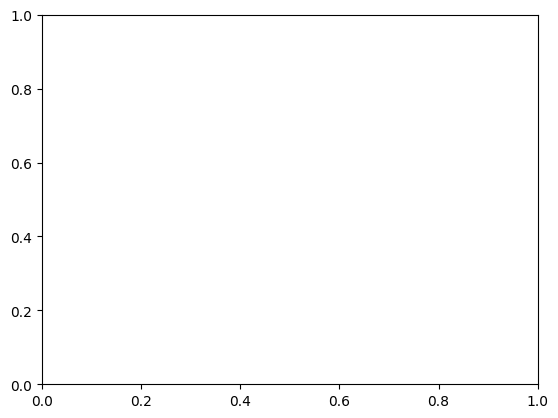

In [17]:
plt.plot(lri, lossi)

In [ ]:
plt.plot(stepi, lossi)

In [ ]:
torch.randint(0, X.shape[0], (32,))

In [ ]:
# loss for all of X
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss.item()


In [ ]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss.item()

In [ ]:
plt.figure(figsize=(8, 8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
  plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha='center', va='center', color='white')
plt.grid('minor')

In [ ]:
# train split,             dev/validation split,        test split
# to train params         to train hyperparams          to test performance